In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import *
import random
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('../../raw/LiChuan/trainallfeatures.csv')
test = pd.read_csv('../../raw/LiChuan/test_feature.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [3]:
train

,TR_0,TR_1,TR_4,TR_5,TR_5;4,TR_6,TR_7,TR_8,TR_8;7,TR_9,...,sale_quantity_last_2M_min,sale_quantity_last_2M_mean,sale_quantity_last_2M_std,sale_quantity_last_2M_median,sale_quantity_last_12M_sum,sale_quantity_last_12M_max,sale_quantity_last_12M_min,sale_quantity_last_12M_mean,sale_quantity_last_12M_std,sale_quantity_last_12M_median
0,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,1,0,1,1,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0,0,1,1,0,1,1,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0,0,1,1,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
5,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
6,0,0,1,1,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
7,0,0,0,1,0,1,1,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
8,1,0,0,1,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
9,0,0,0,0,0,1,0,0,0,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [3]:
# 去掉 2012 年数据, 噪音太多
train = train[train['year']!=2012]

In [4]:
train.drop_duplicates(inplace=True)
labels = train.sale_quantity
train = train.drop(['class_id','sale_quantity', 'sale_date'], axis=1)

train_test = pd.concat([train, test]).reset_index(drop=True)
year_dummies = pd.get_dummies(train_test['year'], prefix='year')
month_dummies = pd.get_dummies(train_test['month'], prefix='month')
train_test = pd.concat([train_test, year_dummies], axis=1)
train_test = pd.concat([train_test, month_dummies], axis=1)
train_test = train_test.drop(['year', 'month'], axis=1)
train_test.fillna(0.0, inplace=True)

test = train[8120:].reset_index(drop=True)
test_labels = labels[8120:]
train = train[:8120].reset_index(drop=True)
labels = labels[:8120]

In [5]:
train.shape, test.shape

((8120, 183), (140, 183))

In [6]:
# train = train[['how_many_month_has_sell', 'sale_quantity_this_last_month','sale_quantity_this_last_year','sale_quantity_total_last_month','sale_quantity_total_last_year','this_month_sale_class_count','total_quality_max','total_quality_mean','total_quality_min','year','month']]
# test = test[['how_many_month_has_sell', 'sale_quantity_this_last_month','sale_quantity_this_last_year','sale_quantity_total_last_month','sale_quantity_total_last_year','this_month_sale_class_count','total_quality_max','total_quality_mean','total_quality_min','year','month']]

* http://xgboost.readthedocs.io/en/latest/parameter.html 官方参数介绍
* http://blog.csdn.net/zc02051126/article/details/46711047 XGBoost 中文参数介绍
* [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

### XGBoost

In [7]:
# 原始版本参数 RMSE = 141, 2018年02月01日
rmses = []
for i in range(5):    
    train_X,test_X, train_y, test_y = train_test_split(train,  
                                                        labels,  
                                                        test_size = 0.05)
    
    trainset = xgb.DMatrix(train_X,label=train_y)
    testset = xgb.DMatrix(test_X)
    
    params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
    watchlist = [(trainset,'train')]
    model = xgb.train(params, trainset, num_boost_round=4000)
    predict_test_X = model.predict(testset)
    rmsetmp = sp.sqrt(sp.mean((test_y - predict_test_X) ** 2))
    
    print('This time rmse is: '+ str(rmsetmp))
    rmses.append(rmsetmp)
    
def Get_Average(list):
    sum = 0
    for item in list:
        sum += item
    return sum/len(list)
    
print('Mean rmse of these is:' + str(Get_Average(rmses)))

This time rmse is: 131.894723149
This time rmse is: 160.180995289
This time rmse is: 242.153145144
This time rmse is: 230.307622929
This time rmse is: 168.37481519
Mean rmse of these is:186.58226034


In [7]:
# result_20180204_xgboost0.7.csv
rmses = []
for i in range(5):    
    train_X,test_X, train_y, test_y = train_test_split(train,  
                                                        labels,  
                                                        test_size = 0.05)
    
    trainset = xgb.DMatrix(train_X,label=train_y)
    testset = xgb.DMatrix(test_X)
    
    params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.7, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.7, # 在建立树时对特征采样的比例。
    'colsample_bylevel':0.7,
    'eta': 0.01,
    'nthread':12,
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
    watchlist = [(trainset,'train')]
    model2 = xgb.train(params, trainset, num_boost_round=4000)
    predict_test_X = model2.predict(testset)
    rmsetmp = sp.sqrt(sp.mean((test_y - predict_test_X) ** 2))
    
    print('This time rmse is: '+ str(rmsetmp))
    rmses.append(rmsetmp)
    
def Get_Average(list):
    sum = 0
    for item in list:
        sum += item
    return sum/len(list)
    
print('Mean rmse of these is:' + str(Get_Average(rmses)))

This time rmse is: 124.989057349
This time rmse is: 123.398550722
This time rmse is: 149.170716796
This time rmse is: 136.145964349
This time rmse is: 143.333705126
Mean rmse of these is:135.407598869


In [8]:
rmses = []
for i in range(5):    
    train_X,test_X, train_y, test_y = train_test_split(train,  
                                                        labels,  
                                                        test_size = 0.05)
    
    trainset = xgb.DMatrix(train_X,label=train_y)
    testset = xgb.DMatrix(test_X)
    
    params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
    watchlist = [(trainset,'train')]
    model3 = xgb.train(params, trainset, num_boost_round=4000)
    predict_test_X = model3.predict(testset)
    rmsetmp = sp.sqrt(sp.mean((test_y - predict_test_X) ** 2))
    
    print('This time rmse is: '+ str(rmsetmp))
    rmses.append(rmsetmp)
    
def Get_Average(list):
    sum = 0
    for item in list:
        sum += item
    return sum/len(list)
    
print('Mean rmse of these is:' + str(Get_Average(rmses)))

This time rmse is: 170.177100726
This time rmse is: 246.263492292
This time rmse is: 153.916091788
This time rmse is: 150.690281264
This time rmse is: 115.692277069
Mean rmse of these is:167.347848628


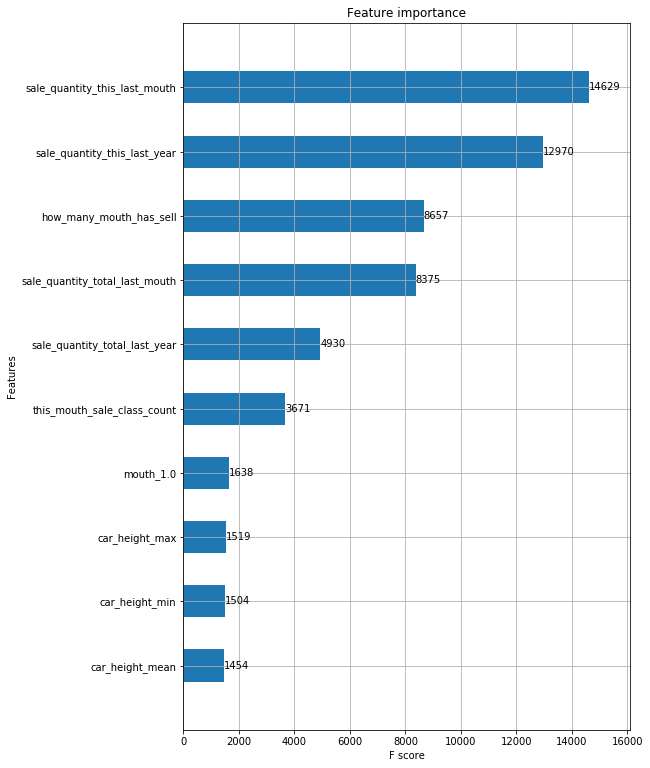

In [20]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model2, max_num_features=10, height=0.5, ax=ax)

In [16]:
test_set = xgb.DMatrix(test)
prediction = model2.predict(test_set)

In [17]:
submit['predict_quantity'] = prediction

In [19]:
submit.to_csv('../../raw/LiChuan/result_20180204_xgboost-inclued-2012.csv',index=False, header=True)  

### RandomForestRegressor

In [ ]:
train_X,test_X, train_y, test_y = train_test_split(train,  
                                                   labels,  
                                                   test_size = 0.05)

In [43]:
# Establish model
model = RandomForestRegressor(n_estimators=30, n_jobs=-1)
model.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [44]:
predict_test_X = model.predict(test_X)
rmsetmp = sp.sqrt(sp.mean((test_y - predict_test_X) ** 2))

print('This time rmse is: '+ str(rmsetmp))
rmses.append(rmsetmp)

This time rmse is: 180.095413626


In [45]:
prediction = model.predict(test)

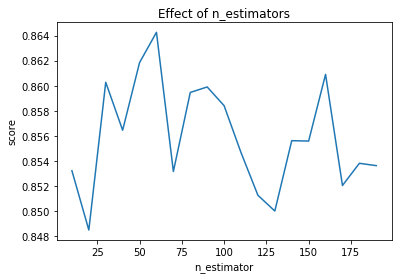

In [47]:
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(train_X, train_y)
    scores.append(model.rmse(test_X, test_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("rmse")
plt.plot(estimators, scores)